In [1]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torchvision import transforms, utils,datasets
from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image

import glob

##### Define data paths

In [2]:
#get all image and mask paths
image_paths = glob.glob("C:\\Users\\Alexandra\\Desktop\\thesis\\7_week\\topostruct\\data\\img\\*.jpg")
mask_paths = glob.glob("C:\\Users\\Alexandra\\Desktop\\thesis\\7_week\\topostruct\\data\\msk\\*.jpg")

#split paths
len_images = len(image_paths)
print(len_images)
train_size = 0.6

#length of image and mask folder is the same
train_image_paths = image_paths [:int(len_images*train_size)]
test_image_paths = image_paths[int(len_images*train_size):]

train_mask_paths = mask_paths [:int(len_images*train_size)]
test_mask_paths = mask_paths[int(len_images*train_size):]


15


In [3]:
torch.set_printoptions(profile="full")

##### Custom dataset

In [4]:
#dataset class
class image_dataset(Dataset):
    def __init__(self, images, masks, train=True):
        self.images = images
        self.masks = masks
#         self.num_classes = num_classes
#         self.transforms = transforms

    def transform(self, image,mask):
        resize_im = transforms.Resize(size = (256,256), interpolation=Image.NEAREST)
        resize_m = transforms.Resize(size = (256,256), interpolation=Image.NEAREST)
        gray =  transforms.Grayscale(num_output_channels=1)
        
        image = resize_im(image)
        mask = resize_m(mask)
        
        image = gray(image)
        mask = gray(mask)
        
        
        ####
        image = TF.to_tensor(image)
        mask = TF.to_tensor(mask)
        mask = mask.__ge__(0.7).type(torch.FloatTensor) 
        return image,mask
        
    def __getitem__(self, idx):
        image = Image.open(self.images[idx])
        mask = Image.open(self.masks[idx])        
        x,y = self.transform(image,mask)
        return x,y
        
    def __len__(self):
        return len(self.images)


In [5]:
train_data = image_dataset(train_image_paths, train_mask_paths, train=True)
train_loader = DataLoader(train_data, batch_size = 3, shuffle = True)

test_data = image_dataset(test_image_paths, test_mask_paths, train = False)
test_loader = DataLoader(test_data, batch_size = 3, shuffle = False)

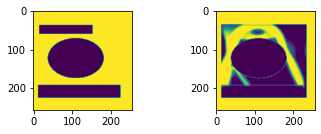

torch.Size([1, 256, 256])


In [6]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(train_data[0][1][0])
ax2 = fig.add_subplot(2,2,2)
ax2.imshow(train_data[0][0][0])
plt.show()
#print(train_data[1][1])
print(train_data[0][0].shape)

In [7]:
# Use gpu for training if available else use cpu
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [8]:
def Conv_double(in_chans, out_chans):
    conv = nn.Sequential(
        nn.Conv2d(in_chans,out_chans, kernel_size =3,padding =1),
        nn.BatchNorm2d(out_chans),
        nn.ReLU(inplace = True),
        nn.Conv2d(out_chans, out_chans, kernel_size =3,padding = 1),
        nn.BatchNorm2d(out_chans),
        nn.ReLU(inplace=True)
    )
    return conv

def Crop_tensor(source, target):
    target_size = target.size()[2]
    source_size = source.size()[2]
    d = source_size - target_size
    if d>1:
        d = (int)(d // 2)
        return source[:,:,d:source_size-d, d:source_size-d]
    else:
        return source[:,:,d:source_size, d:source_size]

In [9]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.maxpool = nn.MaxPool2d(kernel_size =2, stride =2)
        
        #convolutions
        self.down_conv1 = Conv_double(1,64)
        self.down_conv2 = Conv_double(64, 128)
        self.down_conv3 = Conv_double(128, 256)
        self.down_conv4 = Conv_double(256, 512)
        self.down_conv5 = Conv_double(512, 1024)
        
        #up-convolutions
        self.conv_trans1 = nn.ConvTranspose2d(in_channels = 1024, out_channels = 512, kernel_size=2, stride=2)
        self.up_conv1 = Conv_double(1024, 512)
        
        self.conv_trans2 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size=2, stride=2)
        self.up_conv2 = Conv_double(512, 256)
        
        self.conv_trans3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size=2, stride=2)
        self.up_conv3 = Conv_double(256, 128)
        
        self.conv_trans4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size=2, stride=2)
        self.up_conv4 = Conv_double(128, 64)
    
        #output
        self.out = nn.Conv2d(in_channels = 64, out_channels = 1,kernel_size=1)
        
    def forward(self, img):
        #bs,c,h,w
        #encoder
        x1 = self.down_conv1(img) #        
        x2 = self.maxpool(x1)
        x3 = self.down_conv2(x2)   #
        x4 = self.maxpool(x3)
        x5 = self.down_conv3(x4)   #
        x6 = self.maxpool(x5)
        x7 = self.down_conv4(x6)   #
        x8 = self.maxpool(x7)
        x9 = self.down_conv5(x8)   
        
        #decoder
        x = self.conv_trans1(x9)  
        #crop tensor
        y = Crop_tensor(x7, x)        
        #conacatenate
        x = self.up_conv1(torch.cat([x,y],1))
        
        x = self.conv_trans2(x)        
        y = Crop_tensor(x5, x)        
        x = self.up_conv2(torch.cat([x,y],1))
        
        x = self.conv_trans3(x)        
        y = Crop_tensor(x3, x)
        x = self.up_conv3(torch.cat([x,y],1))
        
        x = self.conv_trans4(x)        
        y = Crop_tensor(x1, x)
        x = self.up_conv4(torch.cat([x,y],1))
        
        x = self.out(x)
        
        return x
  

In [10]:
model = UNet()
model = model.to(device)
#print(model)

In [11]:
learning_rate = 0.001
criterion = nn.BCEWithLogitsLoss()
#criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [12]:
# The training loop
epochs = 500
total_steps = len(train_loader)
#print(f"{epochs} epochs, {total_steps} total_steps per epoch")
for epoch in range(epochs):
    for i, (images, masks) in enumerate(train_loader):
       
          #images_batch = torch.from_numpy(np.array(images))
#         masks_batch = torch.from_numpy(np.array(masks))
  
        images = images.to(device)
#        masks = masks.type(torch.LongTensor)
#        masks = masks.reshape(masks.shape[0], masks.shape[2], masks.shape[3])
        masks = masks.to(device)
        
        #print(images.shape)
        # Forward pass
        outputs = model(images)
        
        softmax = torch.nn.functional.log_softmax(outputs, dim=1)
#        sigmoid = nn.Sigmoid()
        
#        out = sigmoid(outputs)
        loss = criterion(outputs, masks)
       
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
         
        if (i) % 100 == 0:
            print (f"Epoch [{epoch + 1}/{epochs}], Step [{i}/{total_steps}], Loss: {loss.item():4f}")

Epoch [1/500], Step [0/3], Loss: 0.682459
Epoch [2/500], Step [0/3], Loss: 0.400525
Epoch [3/500], Step [0/3], Loss: 0.405463
Epoch [4/500], Step [0/3], Loss: 0.354901
Epoch [5/500], Step [0/3], Loss: 0.328074
Epoch [6/500], Step [0/3], Loss: 0.272830
Epoch [7/500], Step [0/3], Loss: 0.256415
Epoch [8/500], Step [0/3], Loss: 0.228883
Epoch [9/500], Step [0/3], Loss: 0.211439
Epoch [10/500], Step [0/3], Loss: 0.182892
Epoch [11/500], Step [0/3], Loss: 0.170930
Epoch [12/500], Step [0/3], Loss: 0.183051
Epoch [13/500], Step [0/3], Loss: 0.166044
Epoch [14/500], Step [0/3], Loss: 0.155861
Epoch [15/500], Step [0/3], Loss: 0.134416
Epoch [16/500], Step [0/3], Loss: 0.121397
Epoch [17/500], Step [0/3], Loss: 0.123297
Epoch [18/500], Step [0/3], Loss: 0.100713
Epoch [19/500], Step [0/3], Loss: 0.104711
Epoch [20/500], Step [0/3], Loss: 0.107193
Epoch [21/500], Step [0/3], Loss: 0.097472
Epoch [22/500], Step [0/3], Loss: 0.090093
Epoch [23/500], Step [0/3], Loss: 0.075542
Epoch [24/500], Step

Epoch [190/500], Step [0/3], Loss: 0.001623
Epoch [191/500], Step [0/3], Loss: 0.002021
Epoch [192/500], Step [0/3], Loss: 0.001720
Epoch [193/500], Step [0/3], Loss: 0.001611
Epoch [194/500], Step [0/3], Loss: 0.001410
Epoch [195/500], Step [0/3], Loss: 0.001617
Epoch [196/500], Step [0/3], Loss: 0.001492
Epoch [197/500], Step [0/3], Loss: 0.001655
Epoch [198/500], Step [0/3], Loss: 0.001538
Epoch [199/500], Step [0/3], Loss: 0.001461
Epoch [200/500], Step [0/3], Loss: 0.001357
Epoch [201/500], Step [0/3], Loss: 0.001432
Epoch [202/500], Step [0/3], Loss: 0.001398
Epoch [203/500], Step [0/3], Loss: 0.001373
Epoch [204/500], Step [0/3], Loss: 0.001422
Epoch [205/500], Step [0/3], Loss: 0.001611
Epoch [206/500], Step [0/3], Loss: 0.001348
Epoch [207/500], Step [0/3], Loss: 0.001419
Epoch [208/500], Step [0/3], Loss: 0.001429
Epoch [209/500], Step [0/3], Loss: 0.001281
Epoch [210/500], Step [0/3], Loss: 0.001323
Epoch [211/500], Step [0/3], Loss: 0.001246
Epoch [212/500], Step [0/3], Los

KeyboardInterrupt: 

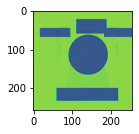

In [13]:
fig = plt.figure()
ax1 = fig.add_subplot(2,2,1)
ax1.imshow(np.squeeze(outputs[2].cpu().detach().numpy()))
plt.show()

In [ ]:
images[0]

In [ ]:
out[0]

In [ ]:
criterion(out[0],images[0])

image shape: torch.Size([3, 1, 256, 256])
output shape: torch.Size([3, 1, 256, 256])


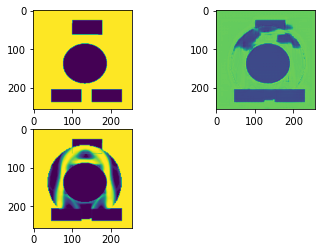

image shape: torch.Size([3, 1, 256, 256])
output shape: torch.Size([3, 1, 256, 256])


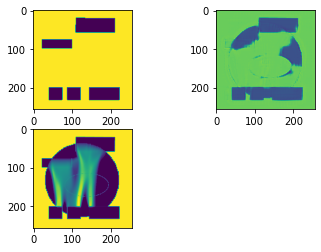

In [17]:
for i, (images, masks) in enumerate(test_loader):
    images = images.to(device)
    output = model(images)
    
    print("image shape:", masks.shape)
    print("output shape:", output.shape)

    fig = plt.figure()
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(np.squeeze(masks[0].cpu().detach().numpy()))
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(np.squeeze(output[0].cpu().detach().numpy()))
    
    ax3 = fig.add_subplot(2,2,3)
    ax3.imshow(np.squeeze(images[0].cpu().detach().numpy()))
    
    plt.show()


In [ ]:
image = Image.open('test_textures/boat.jpg')
img = image.resize((300,300))
img = img.convert('L')
display(img)
print(img)
print(img.size)

#connvert to tensor
trans1 = transforms.ToTensor()
img = trans1(img).view(1,1,300,300)
print(img.shape)

In [ ]:
image = torch.rand((1,1,300,300))

In [ ]:
outputs = model(img.to(device))
img1 = np.squeeze(outputs[0].cpu().detach().numpy())
print(img1.shape)
plt.imshow(img1)
plt.show()


In [ ]:
img3 = np.squeeze(myImage.detach().numpy())
img3 = (img3)
print(img3.shape)
plt.imshow(img3)
plt.show()